In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter
import statsmodels.api as sm
from adjustText import adjust_text
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

print(os.getcwd())
# os.chdir('../')
print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Step 1: Structural Comparison

In [2]:
def structural_comparison(df):
    """
    Aggregates conversation-level metrics and plots structural differences across negotiation categories.
    """
    category_colors = {
        "Friendly": "#1F77B4",
        "Constructive": "#FF7F0E",
        "Apathetic": "#7F7F7F",
        "Destructive": "#D62728"
    }

    # Aggregate to conversation level
    convo_df = df.groupby("PairID").agg({
        "Negotiation_Category": "first",
        "Turn": "max",
        "Contested": lambda x: (x > 0).sum(),
        "Sentiment": "mean",
        "word_count": "mean"
    }).rename(columns={
        "Turn": "Avg_No._of_turns",
        "Contested": "Avg_prop_contested_turns",
        "Sentiment": "Avg_Sentiment",
        "word_count": "Avg_word_count_per_turn"
    }).reset_index()

    # Melt for plotting
    melted = convo_df.melt(id_vars="Negotiation_Category", 
                            value_vars=["Avg_No._of_turns", "Avg_prop_contested_turns", "Avg_Sentiment", "Avg_word_count_per_turn"],
                            var_name="Metric", value_name="Value")

    # Compute means and standard error
    summary = melted.groupby(["Negotiation_Category", "Metric"]).agg(
        Mean_Value=("Value", "mean"),
        Std_Error=("Value", lambda x: x.std() / np.sqrt(len(x)))
    ).reset_index()

    # Create point plots with improved aesthetics
    sns.set(style="white", font_scale=1.8)
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.direction'] = 'out'
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, gridspec_kw={'hspace': 0.6})
    
    metrics = summary["Metric"].unique()
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_data = summary[summary["Metric"] == metric]
        sorted_categories = metric_data["Negotiation_Category"].tolist()
        colors = [category_colors[cat] for cat in sorted_categories]

        sns.pointplot(
            y="Negotiation_Category", x="Mean_Value", data=metric_data,
            hue="Negotiation_Category", palette=category_colors, dodge=False,
            errorbar=None, markers="o", linestyles="", ax=ax, markersize=12
        )

        for _, row in metric_data.iterrows():
            y_pos = metric_data["Negotiation_Category"].tolist().index(row["Negotiation_Category"])
            ax.errorbar(
            x=row["Mean_Value"],
            y=y_pos,
                xerr=row["Std_Error"],
                fmt='none', ecolor=category_colors[row["Negotiation_Category"]], capsize=5, lw=2
            )

        ax.set_title(metric.replace("_", " "), fontsize=18, weight='semibold', pad=20)
        ax.set_xlabel("")
        if i % 2 == 0:
            ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
        else:
            ax.tick_params(axis='y', which='major', length=6)
            ax.set_yticklabels([])  # This hides labels but not the ticks

        ax.tick_params(axis='y', which='both', length=6)
        ax.set_ylabel("")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', which='both', length=6)

    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call this function using:
# structural_comparison(df)


/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_15290/1215906078.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_15290/1215906078.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_15290/1215906078.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


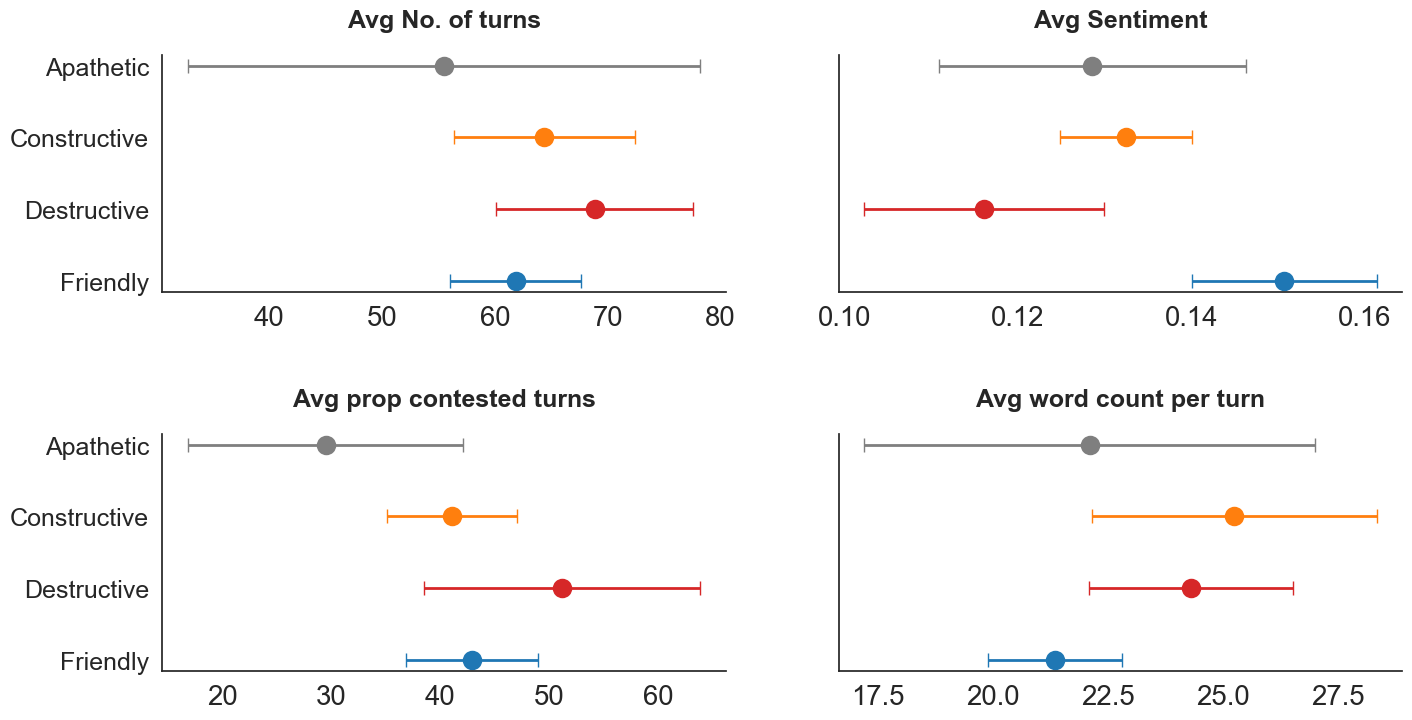

In [3]:
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')
structural_comparison(df)

Step 2: Behavioral Patterns before and during Contested Turns


In [64]:
def analyze_pre_contested_behaviors(df, negotiation_category, n_prior_turns=1):
    """
    For a given negotiation category, compare behavioral patterns during contested turns
    and the n uncontested turns preceding each contested turn.
    """
    # Filter by category
    df_cat = df[df['Negotiation_Category'] == negotiation_category].copy()

    # Ensure sorting for turn-based comparison
    df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)

    # Initialize label column
    df_cat['Label'] = 0  # default: not pre-contested
    
    # Find and label pre-contested turns (Y=1)
    contested_idx = df_cat[df_cat['Contested'] > 0].index
    for idx in contested_idx:
        if idx - n_prior_turns >= 0:
            prior_idx = idx - n_prior_turns
            same_pair = df_cat.loc[prior_idx, 'PairID'] == df_cat.loc[idx, 'PairID']
            if same_pair and df_cat.loc[prior_idx, 'Contested'] == 0:
                df_cat.loc[prior_idx, 'Label'] = 1

    # Exclude contested turns from dataset
    df_filtered = df_cat[df_cat['Contested'] == 0]
    
    print('pior df shape:', df_filtered.shape)


    # Format only behavioral feature column names
    # behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    # rename_map = {col: col.replace('_', ' ').title() for col in behavior_cols}
    # df.rename(columns=rename_map, inplace=True)
    # behavior_cols = list(rename_map.values())

    # # behavioral features
    # feature_start = df.columns.get_loc("Acknowledgement")
    # feature_end = df.columns.get_loc("Smile") + 1
    # behavior_cols = df.columns[feature_start:feature_end]
    
    # Define behavioral feature range using original names
    raw_behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]

    # Rename for presentation
    rename_map = {col: col.replace('_', ' ').title() for col in raw_behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())
    
    print("Behavioral features used:", len(behavior_cols), behavior_cols)


    # Prepare data
    X = df_filtered[behavior_cols]
    y = df_filtered['Label']

    # Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # SHAP summary plot
    # Identify modality for each feature
    vocal_feats = ["Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"]
    facial_feats = ["Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer",
                    "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right",
                    "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose_Openjaw",
                    "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker",
                    "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"]
    
    print(len(facial_feats))

    X_formatted = X.copy()
    
    print(X_formatted.shape)
    
    shap_mean = pd.Series(np.abs(shap_values.values).mean(axis=0), index=X_formatted.columns)
    print(shap_mean.sort_values(ascending=False).head(30))  # see top features
    print("Features with zero SHAP:", (shap_mean == 0).sum())


    # Split top and bottom features for side-by-side presentation
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    # sorted_indices = np.argsort(mean_abs_shap)
    # top_idx = sorted_indices[-10:]
    # bottom_idx = sorted_indices[-20:-10]

    # top_features = X_formatted.columns[top_idx]
    # bottom_features = X_formatted.columns[bottom_idx]
    # X_top = X_formatted.iloc[:, top_idx]
    # X_bottom = X_formatted.iloc[:, bottom_idx]
    
    shap.summary_plot(shap_values, X_formatted, plot_type="dot", show=False, plot_size=(10, 10))
    # plt.title("Beahavioral features", fontsize=14)
    plt.xlabel("SHAP Values:\n← Non-Contested Turn | Pre-Contested Turn →", fontsize=12)
    plt.tight_layout()
    plt.show()
    # shap.summary_plot(shap_values[:, bottom_idx], X_bottom, plot_type="dot", show=False, plot_size=(8, 6))
    # plt.title("Top Features (11–20)", fontsize=14)
    # plt.xlabel("SHAP Values:\nPredictive Power of Contested Turn (→ Right)\nvs. Pre-Contested Turn (← Left)", fontsize=12)
    # plt.tight_layout()
    # plt.show()

    # SHAP scatter comparison
    shap_df = pd.DataFrame({
        'Feature': behavior_cols,
        'SHAP Non-Contested': np.mean(np.abs(shap_values.values[y == 0]), axis=0),
        'SHAP Pre-Contested': np.mean(np.abs(shap_values.values[y == 1]), axis=0)
    })

    # Determine modality for coloring
    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in facial_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    shap_df['Modality'] = shap_df['Feature'].apply(get_modality)

    # Label features significantly different from diagonal
    shap_df['Diff'] = shap_df['SHAP Pre-Contested'] - shap_df['SHAP Non-Contested']
    threshold = 0.03  # customize this threshold
    shap_df['Label'] = shap_df.apply(lambda row: row['Feature'] if abs(row['Diff']) > threshold else '', axis=1)

    plt.figure(figsize=(14, 6))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=shap_df, x='SHAP Non-Contested', y='SHAP Pre-Contested', hue='Modality', palette=palette, s=100, alpha=0.7)
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel('SHAP Value (Non-Contested)')
    plt.ylabel('SHAP Value (Pre-Contested)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
    # Annotate significantly different points
    from adjustText import adjust_text

    texts = []
    for i, row in shap_df[shap_df['Label'] != ''].iterrows():
        x, y = row['SHAP Non-Contested'], row['SHAP Pre-Contested']
        texts.append(plt.text(x, y, row['Label'], fontsize=10, weight='bold', color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), expand_points=(2, 2), expand_text=(2, 2), force_text=0.7)

    plt.tight_layout()
    plt.show()

# Example usage:
# analyze_pre_contested_behaviors(df, negotiation_category="Functional Tension", n_prior_turns=2)


pior df shape: (939, 85)
Behavioral features used: 66 ['Acknowledgement', 'Affirmation', 'Agreement', 'Apology', 'Ask Agency', 'By The Way', 'Can You', 'Conjunction Start', 'Could You', 'Disagreement', 'Filler Pause', 'First Person Plural', 'First Person Single', 'For Me', 'For You', 'Formal Title', 'Give Agency', 'Goodbye', 'Gratitude', 'Hedges', 'Hello', 'Impersonal Pronoun', 'Informal Title', 'Let Me Know', 'Negation', 'Negative Emotion', 'Please', 'Positive Emotion', 'Reasoning', 'Reassurance', 'Second Person', 'Subjectivity', 'Swearing', 'Truth Intensifier', 'Bare Command', 'Yesno Questions', 'Wh Questions', 'Adverb Limiter', 'Token Count', 'Pitch', 'Vocal Intensity', 'Vocal Articulation', 'Vocal Clarity', 'Squintpuffsneer', 'Compressed Contortion', 'Brow Up', 'Cheek Puff Sneer', 'Blink', 'Look Down', 'Look Right', 'Look Left', 'Look Up', 'Blink Right', 'Eyes Wide', 'Open Mouth', 'Jaw Left', 'Jaw Right', 'Mouthclose Openjaw', 'Mouthdimple Left', 'Mouthdimple Right', 'Skeptical Rig

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


23
(939, 66)
Vocal Articulation       0.611495
Vocal Intensity          0.609133
Pitch                    0.558323
Token Count              0.486463
Vocal Clarity            0.430406
Mouth Right              0.388972
Sneering Pucker          0.312555
Skeptical Right          0.284166
Hedges                   0.245574
Impersonal Pronoun       0.226751
Mouthdimple Left         0.205579
Affirmation              0.204564
Eyes Wide                0.181356
Positive Emotion         0.162625
Look Right               0.134129
Conjunction Start        0.117675
Mouthclose Openjaw       0.116196
Brow Up                  0.114166
Hello                    0.112634
Second Person            0.108061
First Person Single      0.107199
Look Up                  0.105792
Look Left                0.098587
Compressed Contortion    0.094434
Reasoning                0.076068
Mouth Shrug              0.067232
First Person Plural      0.066646
Smile                    0.059947
Look Down                0.058497
J

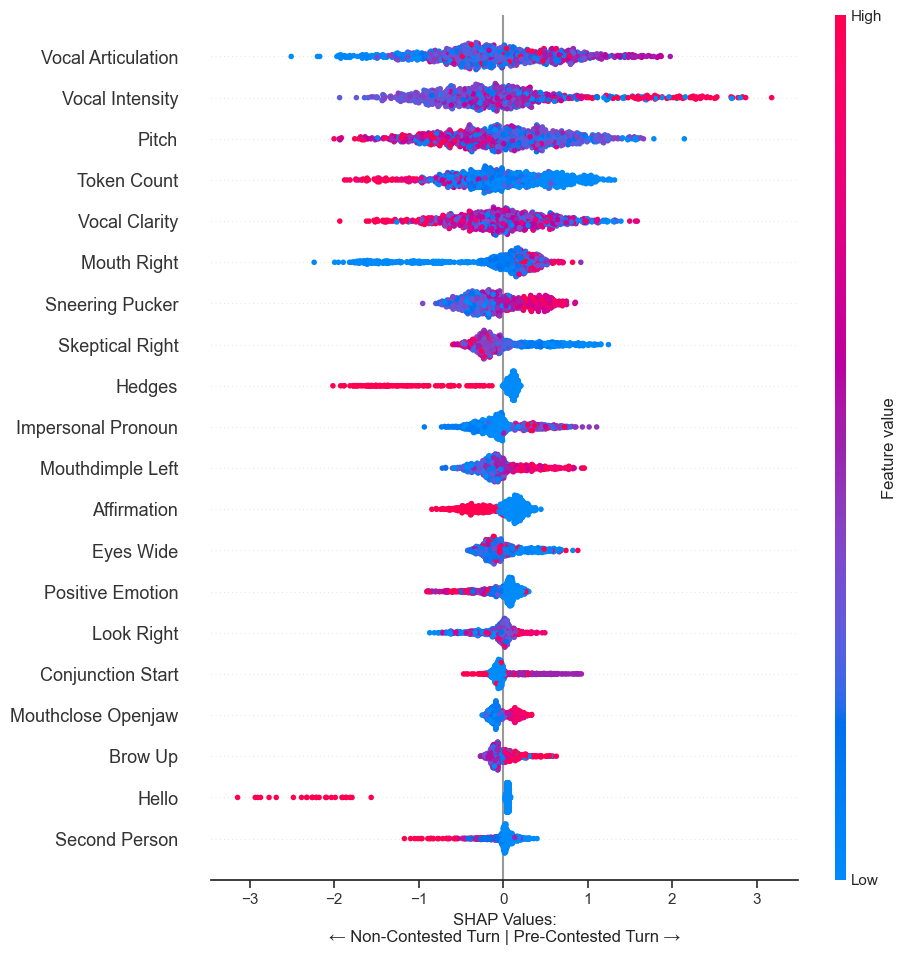

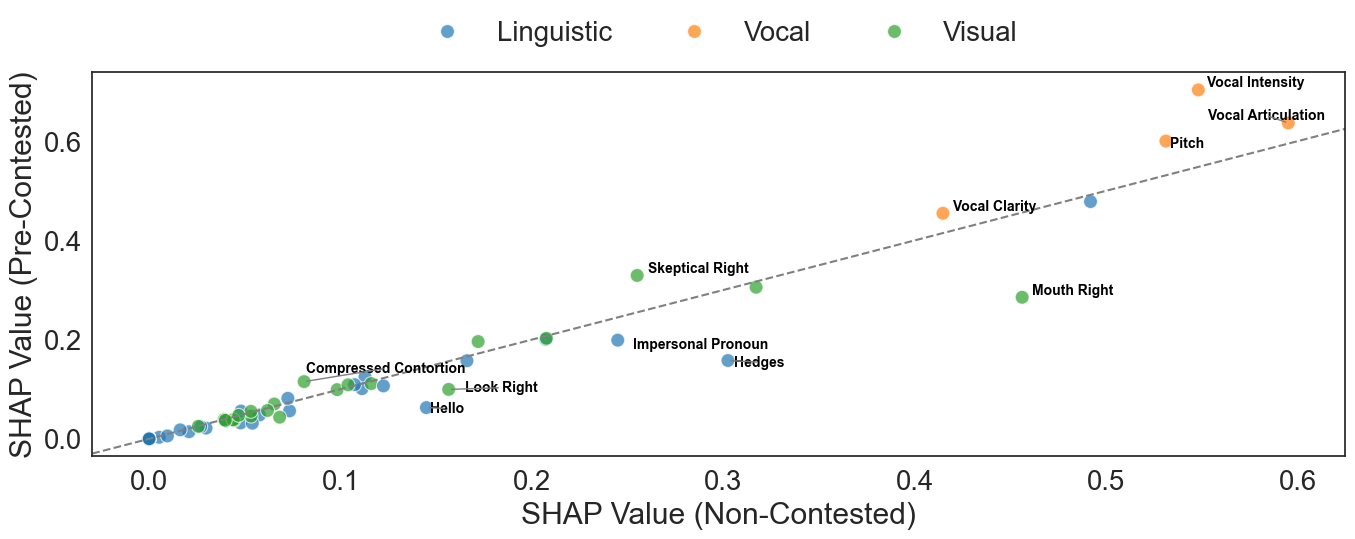

In [63]:
analyze_pre_contested_behaviors(df, negotiation_category="Destructive", n_prior_turns=1)


In [79]:

def prepare_dataset(df, negotiation_category, n_prior_turns=1):
    df_cat = df[df['Negotiation_Category'] == negotiation_category].copy()
    df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)
    df_cat['Label'] = 0
    contested_idx = df_cat[df_cat['Contested'] > 0].index

    for idx in contested_idx:
        if idx - n_prior_turns >= 0:
            prior_idx = idx - n_prior_turns
            same_pair = df_cat.loc[prior_idx, 'PairID'] == df_cat.loc[idx, 'PairID']
            if same_pair and df_cat.loc[prior_idx, 'Contested'] == 0:
                df_cat.loc[prior_idx, 'Label'] = 1

    df_filtered = df_cat[df_cat['Contested'] == 0]
    raw_behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    rename_map = {col: col.replace('_', ' ').title() for col in raw_behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())
    return df_filtered, behavior_cols

def train_xgboost_and_get_shap(df_filtered, behavior_cols):
    X = df_filtered[behavior_cols]
    y = df_filtered['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)
    return X, y, shap_values

def plot_shap_summary(shap_values, X):
    shap.summary_plot(shap_values, X, plot_type="dot", show=False, plot_size=(10, 10))
    plt.xlabel("SHAP Values:\n← Non-Contested Turn | Pre-Contested Turn →", fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_shap_scatter(shap_values, X, y):
    vocal_feats = ["Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"]
    facial_feats = ["Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer",
                    "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right",
                    "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose_Openjaw",
                    "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker",
                    "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"]

    shap_df = pd.DataFrame({
        'Feature': X.columns,
        'SHAP Non-Contested': np.mean(np.abs(shap_values.values[y == 0]), axis=0),
        'SHAP Pre-Contested': np.mean(np.abs(shap_values.values[y == 1]), axis=0)
    })

    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in facial_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    shap_df['Modality'] = shap_df['Feature'].apply(get_modality)
    shap_df['Diff'] = shap_df['SHAP Pre-Contested'] - shap_df['SHAP Non-Contested']
    threshold = 0.03
    shap_df['Label'] = shap_df.apply(lambda row: row['Feature'] if abs(row['Diff']) > threshold else '', axis=1)

    plt.figure(figsize=(14, 6))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=shap_df, x='SHAP Non-Contested', y='SHAP Pre-Contested', hue='Modality', palette=palette, s=100, alpha=0.7)
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel('SHAP Value (Non-Contested)')
    plt.ylabel('SHAP Value (Pre-Contested)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

    texts = []
    for _, row in shap_df[shap_df['Label'] != ''].iterrows():
        texts.append(plt.text(row['SHAP Non-Contested'], row['SHAP Pre-Contested'], row['Label'], fontsize=10, weight='bold', color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), expand_points=(2, 2), expand_text=(2, 2), force_text=0.7)

    plt.tight_layout()
    plt.show()

def compute_cross_modality_shap_interactions(model, X):
    explainer = shap.TreeExplainer(model)
    interaction_values = explainer.shap_interaction_values(X)
    mean_interactions = np.abs(interaction_values).mean(axis=0)
    feature_names = list(X.columns)

    vocal_feats = {"Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"}
    visual_feats = {"Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer",
                    "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right",
                    "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose Openjaw",
                    "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker",
                    "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"}

    def modality(feat):
        if feat in vocal_feats:
            return "Vocal"
        elif feat in visual_feats:
            return "Visual"
        else:
            return "Linguistic"

    results = []
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            mod1 = modality(feature_names[i])
            mod2 = modality(feature_names[j])
            if mod1 != mod2:  # Only cross-modality
                results.append({
                    "Feature 1": feature_names[i],
                    "Feature 2": feature_names[j],
                    "Modality 1": mod1,
                    "Modality 2": mod2,
                    "Mean SHAP Interaction": mean_interactions[i, j]
                })

    return pd.DataFrame(results).sort_values("Mean SHAP Interaction", ascending=False).reset_index(drop=True)


def compute_effect_size_mwu(x1, x2):
    # Rank-biserial correlation effect size
    u_stat, _ = mannwhitneyu(x1, x2, alternative='two-sided')
    n1, n2 = len(x1), len(x2)
    rbc = 1 - (2 * u_stat) / (n1 * n2)
    return rbc

def mannwhitneyu_test(shap_values, X, y):
    shap_array = shap_values.values
    shap_df_values = pd.DataFrame(shap_array, columns=X.columns)
    y = y.reset_index(drop=True)

    shap_pre = shap_df_values[y == 1]
    shap_non = shap_df_values[y == 0]

    results = []
    for col in shap_df_values.columns:
        pre_vals = shap_pre[col]
        non_vals = shap_non[col]
        u_stat, p_val = mannwhitneyu(pre_vals, non_vals, alternative='two-sided')
        effect_size = compute_effect_size_mwu(pre_vals, non_vals)

        results.append({
            'Feature': col,
            'U statistic': u_stat,
            'Effect Size (r)': effect_size,
            'Median SHAP (Pre)': pre_vals.median(),
            'Median SHAP (Non)': non_vals.median(),
            'IQR (Pre)': pre_vals.quantile(0.75) - pre_vals.quantile(0.25),
            'IQR (Non)': non_vals.quantile(0.75) - non_vals.quantile(0.25),
            'p_value': p_val
        })

    df_results = pd.DataFrame(results)
    df_results['p_adj'] = multipletests(df_results['p_value'], method='fdr_bh')[1]
    df_results['significant'] = df_results['p_adj'] < 0.05
    return df_results.sort_values('p_adj')


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


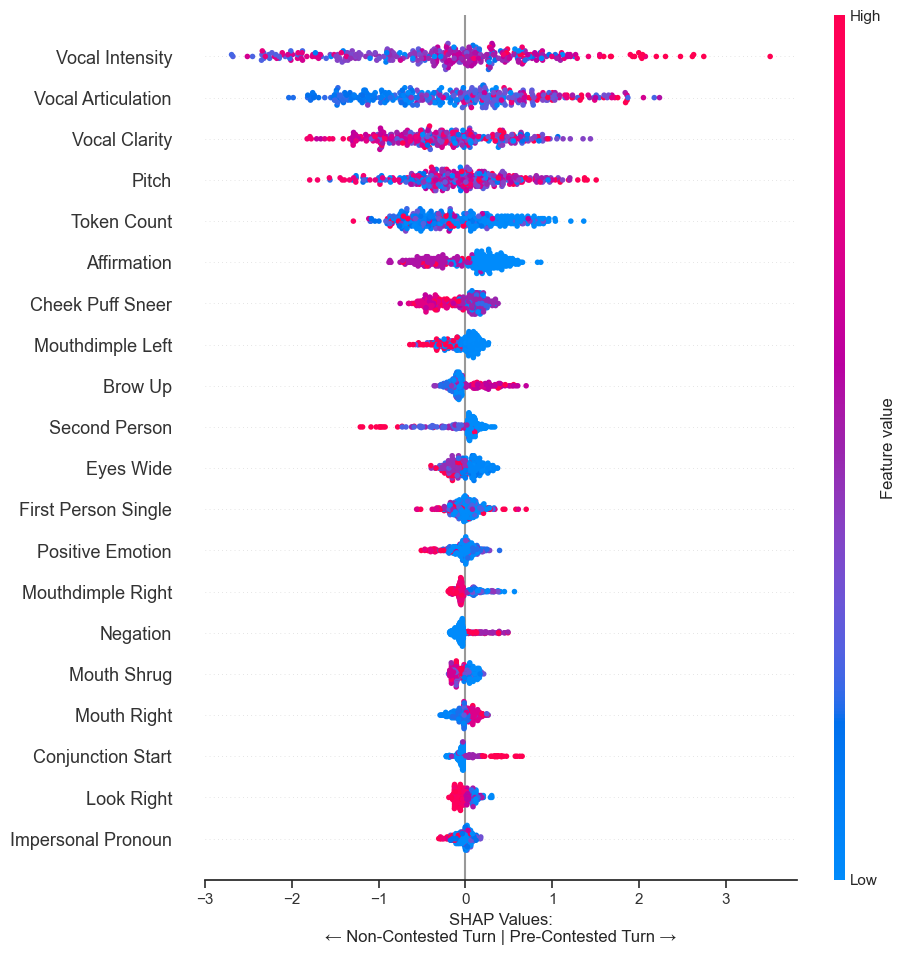

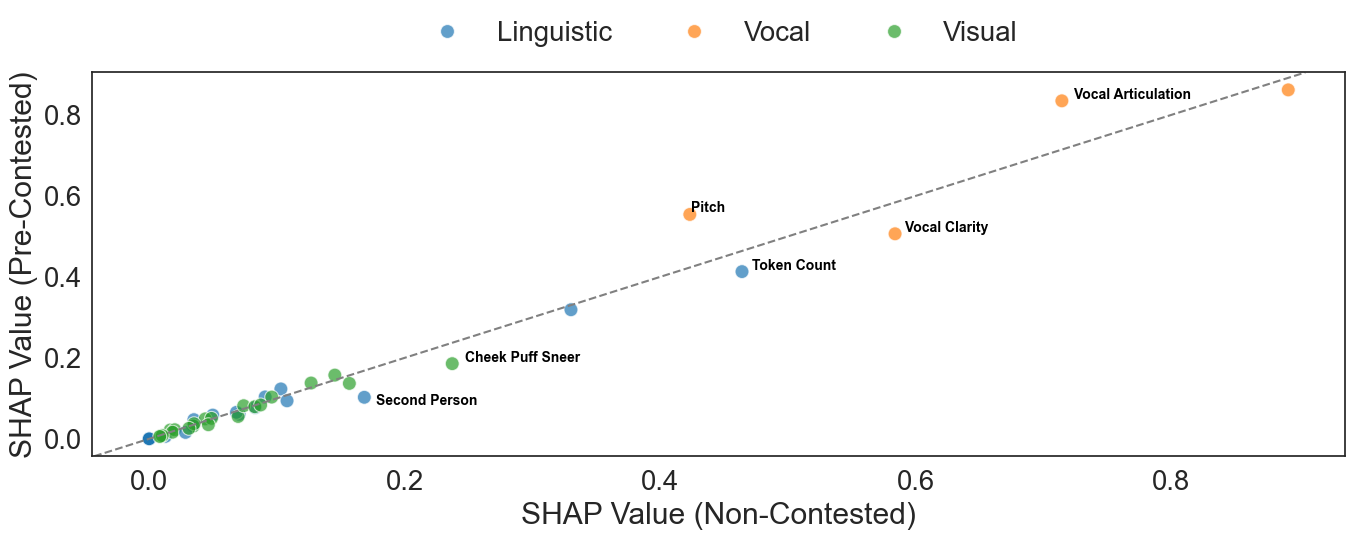

                  Feature  U statistic  Effect Size (r)  Median SHAP (Pre)  \
40        Vocal Intensity      21756.0        -0.708631           0.642127   
39                  Pitch      21311.0        -0.673683           0.421233   
42          Vocal Clarity      21315.0        -0.673997           0.393482   
38            Token Count      20713.0        -0.626718           0.243155   
41     Vocal Articulation      19975.0        -0.568758           0.665377   
12    First Person Single      19209.0        -0.508600           0.075057   
27       Positive Emotion      18460.5        -0.449815           0.039569   
46       Cheek Puff Sneer      17963.0        -0.410744           0.110833   
43        Squintpuffsneer      17282.5        -0.357300           0.038305   
44  Compressed Contortion      17196.0        -0.350507           0.033371   
1             Affirmation      16899.0        -0.327181           0.231819   
37         Adverb Limiter      16888.5        -0.326357         

NameError: name 'model' is not defined

In [ ]:
df_filtered, behavior_cols = prepare_dataset(df, negotiation_category="Apathetic", n_prior_turns=1)
X, y, shap_values, model = train_xgboost_and_get_shap(df_filtered, behavior_cols)
plot_shap_summary(shap_values, X)
plot_shap_scatter(shap_values, X, y)
df_stats = mannwhitneyu_test(shap_values, X, y)
print(df_stats[df_stats['significant']])
interaction_df = compute_cross_modality_shap_interactions(X, y)
print(interaction_df.head(10))




Step 3: Comparing pre-contested turns and predicting contested turn categories
